
<center>
    <h1>Poking Planner</h1>
</center>

Libraries

In [1]:
%matplotlib widget
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
from matplotlib.patches import Rectangle, Circle
from matplotlib.transforms import Affine2D
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols, pi, log, sec, tan, csc
import pandas as pd
import pickle
from deap import base, creator, tools, algorithms
import matplotlib.patches as patches
from scipy.special import ellipk
from scipy.optimize import minimize_scalar
from scipy.integrate import quad
from scipy.optimize import root_scalar
script_folder = os.getcwd()  

GA Parameters

In [2]:
POPULATION_SIZE = 60  # Population size
N_GEN = 300  # Generetation number
MUTATION_ETA = 0.1  # Mutation Parameter
LAMBDA = POPULATION_SIZE  # Child to create for each generation
MU=50 # Population conservation
CXPB = 0.4   # Cross proba
MUTPB = 0.6  # Mutation proba
WEIGHTS=(-1.0, -10.0, 2.0) #For the cost function (Distance error, number of impulse, orientation error)



## Box initialization

In [3]:
L = 0.31 #Length of the box in meter  along y
w= 0.225 #Width of the box in meter  along z
h=0.11 #High of the box in meter  along x
m = 0.91 # Weight kg
box_x=0.464 #Inital pose of the CoM along x in the robot base 
box_y=-0.012 #Inital pose of the CoM along y in the robot base 
box_theta=0 # Inital orientation of the box around z in the robot base 
Young=2200000000 #Young moudulus Pa
sigma=3900000 # dynamic yield strenght Pa
nu= 0.34 # Poisson's ratio


## Target to reach

In [4]:
XTarget,YTarget=0.464,0.012 #position of the target in m over x, position of the target in m over y
thetafinal= math.pi/4  # Final orientation of the box
DistanceTarget=(XTarget**2+YTarget**2)**0.5

Text parameters

In [5]:
WidthArticle=2 #inches
FontArticle=10 #point
width=7#inches
FontFigure=width/WidthArticle*FontArticle
font_name = "Times New Roman"
plt.rcParams['font.family'] = font_name
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = FontFigure
plt.rc('font', size=FontFigure)
plt.rc('axes', titlesize=FontFigure)     # fontsize of the axes title
plt.rc('axes', labelsize=FontFigure)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FontFigure)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FontFigure)    # fontsize of the tick labels
plt.rc('legend', fontsize=FontFigure)    # legend fontsize
plt.rc('figure', titlesize=FontFigure)  # fontsize of the figure title
dpi = 300
script_folder = os.getcwd()
long=width*1/1


## Physics parameters

In [6]:

kimpulse = 6  # Max impulses number
ImpulseMax=0.55 #high limit for the impulse N.m^-1
VelocityMax=1.1 #High limit for the veloicty M.s^-1
g = 9.81 # Gravity
mud = 0.28 #0.27 #0.33  # Dynamic friction coefficient 
mud2= 0.28 #0.27 #0.44  # Second Dynamic friction coefficient in case of orthotropic material
mus = 0.3 # Sattique friction coefficient
# Box
box_d=(w**2+L**2)**0.5 # Diagonale
box_e = 0.003  # Thickness of the cardboard (m)
S=w*L # Surface (m^2)
ImpulseMax=min(ImpulseMax,VelocityMax*m) #Choose the limit
ImpulseMin=ImpulseMax*0.4 #Minimal impulse to poke
marge=0.02 #In order to void the angle of the box, this value indicate a limit (m)
box_ro = m / ((h * w * w) - ((h - 2 * box_e) * (w - 2 * box_e) * (w - 2 * box_e)))  # Volumic mass
# M around z axis
Izz = ((w * L *h * (w ** 2 + L ** 2) / 12) -
        (w - 2 * box_e) * (L - 2 * box_e) *(h - 2 * box_e) * ((w - 2 * box_e) ** 2 + (L - 2 * box_e) ** 2) / 12) * box_ro 



## Friction torque


$C_{f}=\int_{S} \lVert \overrightarrow{cr} \rVert \frac{gm}{S}\mu_{d}\textit{dS}$

In [7]:
ai = w / 2
bi = L / 2
theta = math.pi / 2
p2bornehaute =(bi**3 * (-csc(theta/2)**2/8 - log(math.cos(theta/2))/2 + log(math.sin(theta/2))/2 + sec(theta/2)**2/8)) / 3
theta = 0
p1bornebasse =(ai**3 * (-log(math.cos(theta/2) - math.sin(theta/2)) + log(math.cos(theta/2) + math.sin(theta/2)) + sec(theta) * tan(theta))) / 6 
theta = math.atan(bi / ai)
p1bornehaute = (ai**3 * (-log(math.cos(theta/2) - math.sin(theta/2)) + log(math.cos(theta/2) + math.sin(theta/2)) + sec(theta) * tan(theta))) / 6
p2bornebasse = (bi**3 * (-csc(theta/2)**2/8 - log(math.cos(theta/2))/2 + log(math.sin(theta/2))/2 + sec(theta/2)**2/8)) / 3
p1value = p1bornehaute - p1bornebasse
p2value = p2bornehaute - p2bornebasse
rs = 4 * (p1value + p2value)  
rsymbol = rs / S  
cf = float(mud*g*m*rsymbol) #Friction torque
cf=0.375

## Coefficient of restitution

In [8]:
velocity=1 # V- (m.s^-1)
er=3.1*(sigma/Young/(1-nu**2))**(5/8)*((Young/(1-nu**2)/box_ro)**0.5)**(1/4)
er2=1/(1+er)
print("er=",er,"1/(1+er)=",er2)

er= 0.38036705594353326 1/(1+er)= 0.7244449914203885


In [9]:
def bezier_curve(p0, p1, p2, p3, t):
    bezier = (1 - t)**3 * p0 + 3 * (1 - t)**2 * t * p1 + 3 * (1 - t) * t**2 * p2 + t**3 * p3
    return bezier


## Fitness function 

$g_{1}=|\overrightarrow{OT}-c_{k+1}|$

$g_{2}=k$

$g_{3}=|\theta_{T} - \theta_{c_{k+1}}|$

In [10]:

def FitnessFunction(individu):
    impulse = individu[:kimpulse] #Impulses norm
    n = individu[kimpulse] #Number of impulses
    alpha = individu[kimpulse+1:2*kimpulse+1] # Impulse orientation in the box's base
    Point_S = individu[2*kimpulse+1:3*kimpulse+1] #Impulse localisation in curviligne abcisse
    theta=individu[:kimpulse+1]
    theta[0]=box_theta
    Pointx=[None]*n
    Pointy=[None]*n
    r=[None]*n
    r2=[None]*n
    for i in range(n):
        if Point_S[i]<=L:
            Pointx[i]=Point_S[i]-L/2
            Pointy[i]=w/2
            r[i]=0
            r2[i]=1
        else:
            if Point_S[i]>L and Point_S[i]<=L+w:
                Pointy[i]=w/2-(Point_S[i]-L)
                Pointx[i]=L/2
                r[i]=1
                r2[i]=1
            else:   
                if Point_S[i]>L+w and Point_S[i]<=2*L+w:
                    Pointx[i]=L/2-(Point_S[i]-(L+w))
                    Pointy[i]=-w/2
                    r[i]=0
                    r2[i]=-1
                else:
                    Pointy[i]=Point_S[i]-(2*L+w)-w/2
                    Pointx[i]=-L/2 
                    r[i]=1
                    r2[i]=-1
        alpha[i] = alpha[i] - (1 - r[i]) * r2[i] * math.pi / 2 + r[i] * math.acos(-r2[i])
        mut=float(((mud*math.cos(theta[i]+alpha[i]))**2+(mud2*math.sin(theta[i]+alpha[i]))**2)**0.5)
        theta[i+1] = ((1 / (2*cf*Izz)) *np.sign(np.cross(np.array([Pointx[i],Pointy[i]]),np.array([impulse[i]*math.cos(alpha[i]),impulse[i]*math.sin(alpha[i])]))) * np.cross(np.array([Pointx[i],Pointy[i]]),np.array([impulse[i]*math.cos(alpha[i]),impulse[i]*math.sin(alpha[i])])) ** 2 * np.heaviside((n-i), 0))+theta[i]
        theta[i+1] = ((1 / (2*cf*Izz)) *np.sign(np.cross(np.array([Pointx[i],Pointy[i]]),np.array([impulse[i]*math.cos(alpha[i]),impulse[i]*math.sin(alpha[i])]))) * np.cross(np.array([Pointx[i],Pointy[i]]),np.array([impulse[i]*math.cos(alpha[i]),impulse[i]*math.sin(alpha[i])])) ** 2 * np.heaviside((n-i), 0))+theta[i]
    fitness1 = abs((XTarget-box_x)-((1 / (2*m**2*g*mut)) * sum([np.sign(math.cos(alpha[i]+theta[i])) * (impulse[i]*math.cos(alpha[i]+theta[i])) ** 2 * np.heaviside((n-i), 0) for i in range(n)])))
    fitness12 = abs((YTarget-box_y)-((1 / (2*m**2*g*mut)) * sum([np.sign(math.sin(alpha[i]+theta[i])) * (impulse[i]*math.sin(alpha[i]+theta[i])) ** 2 * np.heaviside((n-i), 0) for i in range(n)])))
    fitness2 = (n-1)/kimpulse
    fitness3=math.cos(thetafinal-theta[n])
    fitness=(fitness1**2+fitness12**2)**0.5
    return fitness, fitness2, fitness3


Mutation custom functions for the GA

In [11]:


def custom_mutate_nrr2(individual):
    for i in range(len(individual)):
        if i < kimpulse:
            if random.random() < MUTPB:
                individual[i] = max(ImpulseMin, min(ImpulseMax, individual[i] + random.uniform(-MUTATION_ETA, MUTATION_ETA)))
        elif i == kimpulse:
            if random.random() < MUTPB:
                individual[i] = random.randint(1, kimpulse)
        elif i > kimpulse and i <= 2*kimpulse:
            if random.random() < MUTPB:
                individual[i] = random.uniform( -math.pi/6, math.pi/6)
        elif i > 2*kimpulse and i <= 3*kimpulse:
            if random.random() < MUTPB:
                for interval in intervals:
                    if interval[0] <= individual[i] <= interval[1]:
                        break  
                chosen_interval = interval
                individual[i] = max(chosen_interval[0], min(chosen_interval[1], individual[i] + random.uniform(-MUTATION_ETA, MUTATION_ETA)))
    return individual,
def generate_custom_attr_S():
    global intervals 
    intervals = [
        (marge, L-marge),
        (L+marge, (L+w)-marge),
        ((L+w)+marge, (2*L+w)-marge),
        ((2*L+w)+marge, (2*L+2*w)-marge)
    ]
    chosen_interval = random.choice(intervals)
    return random.uniform(chosen_interval[0], chosen_interval[1])

def mutate_custom_attr_S(individual):
    index_to_mutate = random.randint(0, len(individual) - 1)
    chosen_interval = intervals[index_to_mutate]
    individual[index_to_mutate] = random.uniform(chosen_interval[0], chosen_interval[1])

creator.create("FitnessMulti", base.Fitness, weights=WEIGHTS)
creator.create("Individual", list, fitness=creator.FitnessMulti)
toolbox = base.Toolbox()
toolbox.register("attr_impulse", random.uniform, ImpulseMin, ImpulseMax)
toolbox.register("attr_alpha", random.uniform, -math.pi/6, math.pi/6)
toolbox.register("attr_n", random.randint, 1, kimpulse) # at least 1 impulse
toolbox.register("attr_S", generate_custom_attr_S)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_impulse,)*kimpulse + (toolbox.attr_n,) + (toolbox.attr_alpha,)*kimpulse +(toolbox.attr_S,)* kimpulse)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate",FitnessFunction)
toolbox.register("mate", tools.cxUniform,indpb=CXPB)
toolbox.register("mutate", custom_mutate_nrr2)
toolbox.register("select", tools.selNSGA2)

Display

In [12]:

def Evolution_Show(solution, elite_num,filename, savedIDX):
    AngularFrictionCoef=float(cf*Izz*2)
    fig, ax = plt.subplots(figsize=(width, long))
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-1, 1)
    ax.set_aspect('equal')
    ax.set_xlabel('X(m)')
    ax.set_ylabel('Y(m)')
    # ax.set_title(f"Box's travel")
    colors2=["#c75980",
"#7dad3c",
"#7968d7",
"#cf832d",
"#6a8bc8",
"#cc594c",
"#3dbbb8",
"#b963b7",
"#50a56e",
"#9b874a"]
    color_index = 0  
    # Point P initialization 
    p_xb = -box_x
    p_yb = -box_y
    #Box init
    x=box_x
    y=box_y
    # Normal init
    nux=0
    nuy=0
    impulse = solution[:kimpulse]
    n = solution[kimpulse]
    alpha = solution[kimpulse+1:2*kimpulse+1]
    Point_S = solution[2*kimpulse+1:3*kimpulse+1]
    data = {"Point x":[],"Point y":[], "Impulse x": [], "Impulse y": [],"Point x local": [], "Point y local": [],"xbox": [], "ybox": [], "thetabox": []}
    theta=solution[:kimpulse+1]
    theta[0]=box_theta 
    Pointx=[None]*n
    Pointy=[None]*n
    r=[None]*n
    r2=[None]*n
    Point_S = solution[2*kimpulse+1:3*kimpulse+1]
    for i in range(n):
        if Point_S[i]<=L:
            Pointx[i]=Point_S[i]-L/2
            Pointy[i]=w/2
            r[i]=0
            r2[i]=1
        else:
            if Point_S[i]>L and Point_S[i]<=L+w:
                Pointy[i]=w/2-(Point_S[i]-L)
                Pointx[i]=L/2
                r[i]=1
                r2[i]=1
            else:   
                if Point_S[i]>L+w and Point_S[i]<=2*L+w:
                    Pointx[i]=L/2-(Point_S[i]-(L+w))
                    Pointy[i]=-w/2
                    r[i]=0
                    r2[i]=-1
                else:
                    Pointy[i]=Point_S[i]-(2*L+w)-w/2
                    Pointx[i]=-L/2 
                    r[i]=1
                    r2[i]=-1
        alpha[i] = alpha[i] - (1 - r[i]) * r2[i] * math.pi / 2 + r[i] * math.acos(-r2[i])
        mut=float(((mud*math.cos(theta[i]+alpha[i]))**2+(mud2*math.sin(theta[i]+alpha[i]))**2)**0.5)
        color = colors2[color_index]
        if i>0:
            p_xb = (1 - r[i-1]) * Pointx[i-1] + r[i-1] * r2[i-1] * L / 2
            p_yb= r[i-1] * Pointy[i-1] + (1 - r[i-1]) * r2[i-1] * w / 2
        # Impulse localiation
        impulse_x =impulse[i] * math.cos(alpha[i])
        impulse_y =impulse[i] * math.sin(alpha[i])
        plaunchx=Pointx[i]-impulse_x/m/2
        plaunchy=Pointy[i]-impulse_y/m/2
        # Rectangle at the current step
        rect = plt.Rectangle((-L/2, -w/2,), L, w, angle=0, fill=True, color=color)
        transformRobot = transforms.Affine2D().rotate_around(0, 0, theta[i]).translate(x,y)
        transformRobotimpulse = transforms.Affine2D().rotate_around(0, 0, theta[i]).translate(0,0)
        transform = transforms.Affine2D().rotate_around(0, 0, theta[i]).translate(x,y)+ ax.transData
        if i==0:
            transform2 = transforms.Affine2D().rotate_around(0, 0, theta[i]).translate(x,y)
            transform3=transform2
        else:
            transform2 = transforms.Affine2D().rotate_around(0, 0, theta[i-1]).translate(xb,yb)
            transform3 = transformRobot
        NewCoordinate = transformRobot.transform([Pointx[i],Pointy[i]])
        NewPx, NewPy = NewCoordinate
        NewCoordinate = transformRobotimpulse.transform([impulse_x,impulse_y])
        NewImpulsex, NewImpulsey = NewCoordinate
        rect.set_transform(transform)
        ax.add_patch(rect)
        color_index = (color_index + 1) % len(colors2) 
        color = colors2[color_index]
        # Show impact point and impulse
        p_circle = plt.Circle((Pointx[i], Pointy[i]), radius=0.01, color=color)
        plaunch_circle = plt.Circle((plaunchx, plaunchy), radius=0.01, color=colors2[color_index-1])
        p_circle.set_transform(transform)
        box_transorm=(transformRobot.transform([0,0]))
        p_transformed = transform2.transform([p_xb,p_yb])
        plaunch_circle.set_transform(transform)
        plaunch_transformed = transform3.transform([plaunchx,plaunchy])
        #Point p in robot's base
        pxy_transformed = transform3.transform([Pointx[i],Pointy[i]])
        # Former point p in robot's base
        p_xb=p_transformed[0]
        p_yb=p_transformed[1]
        # Launch point
        plaunchx=plaunch_transformed[0]
        plaunchy=plaunch_transformed[1]
        # Vector between the current point (former impact ) and the close point to the next impact
        rx=(plaunchx-p_xb)/2
        ry=(plaunchy-p_yb)/2
        #Vector's normal
        nx=-ry*2
        ny=rx*2
        #Point on the unit former normal
        pretractx=p_xb+nux*box_d
        pretracty=p_yb+nuy*box_d
        pretractx2=p_xb-nux*box_d
        pretracty2=p_yb-nuy*box_d
        #Point on the current normal
        pavoidx=p_xb+rx+nx
        pavoidy=p_yb+ry+ny
        pavoidx2=p_xb+rx-nx
        pavoidy2=p_yb+ry-ny
        # Vector and imact Point of te current step
        rxb=(pxy_transformed[0]-plaunchx)
        ryb=(pxy_transformed[1]-plaunchy)
        nxb=-ryb/2
        nyb=rxb/2
        nux=nxb/((nxb**2+nyb**2)**0.5)
        nuy=nyb/((nxb**2+nyb**2)**0.5)
        d=((pxy_transformed[0]-pavoidx)**2+(pxy_transformed[1]-pavoidy)**2)**0.5
        d2=((pxy_transformed[0]-pavoidx2)**2+(pxy_transformed[1]-pavoidy2)**2)**0.5
        # Closest solution of the other points
        if d<d2:
            pavoidx=pavoidx2
            pavoidy=pavoidy2
            pretractx=pretractx2
            pretracty=pretracty2
        pavoid_circle = plt.Circle((pavoidx, pavoidy), radius=0.01, color=colors2[color_index-1])
        pretract_circle = plt.Circle((pretractx, pretracty), radius=0.01, color=colors2[color_index-1])
        # Coordinates of the three points
        p0 = p_transformed
        pinit = f"$p_{{\mathrm{{init}}_{i}}}$"
        p1 = np.array([pretractx,pretracty])
        pretract = f"$p_{{\mathrm{{retract}}_{i}}}$"
        p2 = np.array([pavoidx,pavoidy])
        pavoid = f"$p_{{\mathrm{{avoid}}_{i}}}$"
        p3 = plaunch_transformed
        plaunch = f"$p_{{\mathrm{{launch}}_{i}}}$"
        #Display point's name 
        # if i>0: 
        #     ax.text(p1[0] - 0.2, p1[1]-0.09 , pretract, va='center', usetex=True,fontsize=FontFigure*0.8)
        # ax.text(p2[0] + 0.1, p2[1]-0.1 , pavoid, va='center', usetex=True,fontsize=FontFigure*  0.8)
        # ax.text(p3[0] + 0, p3[1]+0 , plaunch, va='center', usetex=True,fontsize=FontFigure* 0.8)
        # Bezier's curve parameters
        t_values = np.linspace(0, 1, 100)
        # Bezier points
        if i>0: 
            curve_points = np.array([bezier_curve(p0, p1, p2,p3, t) for t in t_values])
        else:
            curve_points = np.array([bezier_curve(p0, p2, p2,p3, t) for t in t_values])
        plt.plot(curve_points[:, 0], curve_points[:, 1],linestyle='dashed', label='Dashed Bezier', color=colors2[color_index-1])

        data["Point x"].append(NewPx)
        data["Point y"].append(NewPy)
        data["Point x local"].append(Pointx[i])
        data["Point y local"].append(Pointy[i])
        data["Impulse x"].append(NewImpulsex)
        data["Impulse y"].append(NewImpulsey)
        data["xbox"].append(x)
        data["ybox"].append(y)
        data["thetabox"].append(theta[i])
        ax.add_patch(p_circle)
        ax.add_patch(plaunch_circle)
        ax.add_patch(pavoid_circle)
        if i>0:
            ax.add_patch(pretract_circle)
        ax.arrow(Pointx[i]-impulse_x/2, Pointy[i]-impulse_y/2, impulse_x/2, impulse_y/2, head_width=0.05, head_length=0.1, color=color,transform=transform,length_includes_head=True)
        xb=x
        yb=y
        theta[i+1] = ((1 / AngularFrictionCoef) * np.sign(np.cross(np.array([Pointx[i],Pointy[i]]),np.array([impulse[i]*math.cos(alpha[i]),impulse[i]*math.sin(alpha[i])]))) * np.cross(np.array([Pointx[i],Pointy[i]]),np.array([impulse[i]*math.cos(alpha[i]),impulse[i]*math.sin(alpha[i])])) ** 2 * np.heaviside((n-i), 1)) +theta[i]
        x = box_x+((1 /(2*m**2*g*mut)) * sum([np.sign(math.cos(alpha[j]+theta[j])) * (impulse[j]*math.cos(alpha[j]+theta[j])) ** 2 * np.heaviside((i-j), 1) for j in range(i+1)]))
        y = box_y+((1 /(2*m**2*g*mut)) * sum([np.sign(math.sin(alpha[j]+theta[j])) * (impulse[j]*math.sin(alpha[j]+theta[j])) ** 2 * np.heaviside((i-j), 1) for j in range(i+1)]))
        xabs = ((1 /(2*m**2*g*mut)) * sum([np.sign(math.cos(alpha[j]+theta[j])) * (impulse[j]*math.cos(alpha[j]+theta[j])) ** 2 * np.heaviside((i-j), 1) for j in range(i+1)]))
        yabs = ((1 /(2*m**2*g*mut)) * sum([np.sign(math.sin(alpha[j]+theta[j])) * (impulse[j]*math.sin(alpha[j]+theta[j])) ** 2 * np.heaviside((i-j), 1) for j in range(i+1)]))
        dabs=((x-xb)**2+(y-yb)**2)**0.5
    data["Point x"].append(cf)
    data["Point y"].append(Izz)
    data["Point x local"].append(0)
    data["Point y local"].append(0)
    data["Impulse x"].append(mud)
    data["Impulse y"].append(mud2)
    data["xbox"].append(0)
    data["ybox"].append(0)
    data["thetabox"].append(0)
    rect = plt.Rectangle((-L/2, -w/2,), L, w, angle=0, fill=True, color=color)
    transform = transforms.Affine2D().rotate_around(0, 0, theta[n]).translate(x,y)+ ax.transData
    rect.set_transform(transform)
    ax.add_patch(rect)
    rect = plt.Rectangle((-L/2, -w/2,), L, w, angle=0, fill=False, color='black', linestyle='dotted',linewidth=3)
    transform = transforms.Affine2D().rotate_around(0, 0, thetafinal).translate(XTarget,YTarget)+ ax.transData
    rect.set_transform(transform)
    ax.add_patch(rect)
    ax.grid()
    plt.tight_layout()
    plt.show()
    df = pd.DataFrame(data)
    csv_data = df.to_csv(index=False)
    print(csv_data)
    if Save==True and savedIDX == elite_num :
        output_path = os.path.join(script_folder, filename)
        fig.savefig(output_path, dpi=dpi, bbox_inches="tight")

Main

In [13]:
def main():
    hof = tools.HallOfFame(N_GEN)
    stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(key=len)  
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("min", np.min, axis=0)
    mstats.register("max", np.max, axis=0)
    mstats.register("avg", np.mean, axis=0)
    
    selected_vector = []
    selected_vector.append((XTarget, YTarget))
    # Solver
    population = toolbox.population(n=POPULATION_SIZE)
    population, mlogbook =algorithms.eaMuPlusLambda(population, toolbox, mu=MU, lambda_=LAMBDA, cxpb=CXPB, mutpb=MUTPB, ngen=N_GEN,halloffame=hof, verbose=False, stats=mstats)
    pareto_front = tools.sortLogNondominated(population,len(population),first_front_only=True)
    all_selected_solutions=[]
    count = 0
    for solution in pareto_front:
        if solution.fitness.values[0] < 0.1 and solution.fitness.values[2] > 0.95:
                all_selected_solutions.append(solution)
                count += 1
        if count == 10:
                break
#     all_selected_solutions=pareto_front[:10]
    with open(f'selected_solution_x={round(XTarget,3)}_y={round(YTarget,3)}.pkl', 'wb') as file:
            pickle.dump(all_selected_solutions, file)
    return population,mlogbook,pareto_front,hof


## Execution

In [14]:
population,mlogbook,pareto_front,hof=main()


Loading results

In [15]:
filename = f'selected_solution_x={round(XTarget,3)}_y={round(YTarget,3)}.pkl'
with open(filename, 'rb') as file:
    selected_solutions = pickle.load(file)

## Display results

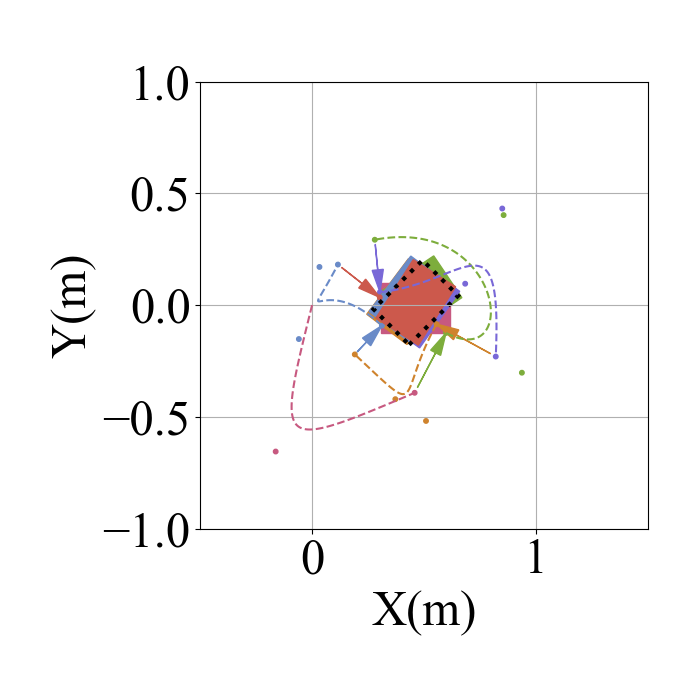

Point x,Point y,Impulse x,Impulse y,Point x local,Point y local,xbox,ybox,thetabox
0.599,-0.1245,0.2553008345313945,0.4871565291439432,0.13499999999999998,-0.1125,0.464,-0.012,0.0
0.30350845981656416,0.05804507633957655,0.04212262100078831,-0.42642609444687635,-0.135,0.1125,0.47832730973678234,0.04016716503617676,0.5928272071960324
0.5564014721874473,-0.08476001942308613,-0.48233530096761795,0.26429653316015594,-0.02441487810587309,-0.1125,0.4787173333972917,0.00019591535110420437,0.9544241429137408
0.31215096257083175,-0.09160733160177523,0.22041794413467491,0.23463358519352462,-0.155,0.027949108379069207,0.42757762149375406,0.015550678220525603,0.9266667122434001
0.30270796124016236,0.034600047247066626,0.3407283918861122,-0.26709145601384726,-0.07593166830455383,0.1125,0.438257199091781,0.02765221525729453,0.9258702033907866
0.375,0.02007978690097894,0.28,0.28,0.0,0.0,0.0,0.0,0.0



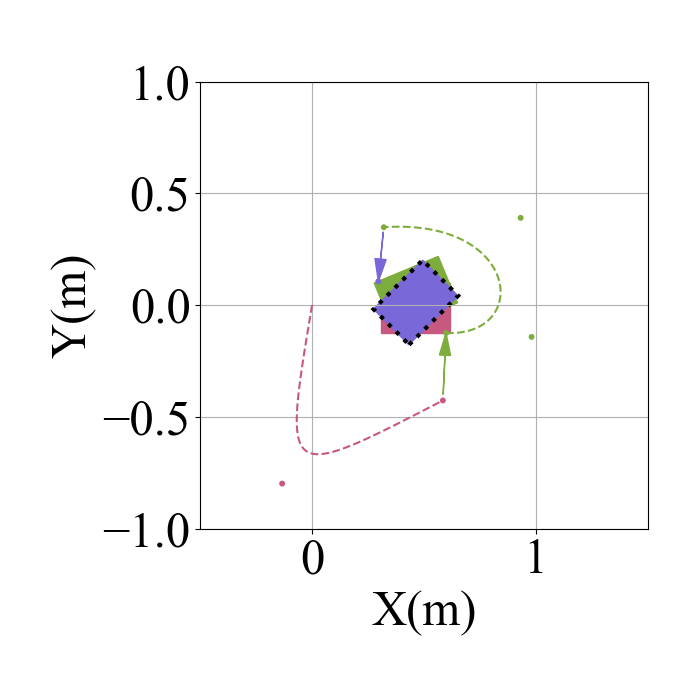

Point x,Point y,Impulse x,Impulse y,Point x local,Point y local,xbox,ybox,thetabox
0.599,-0.1245,0.025545829850936126,0.5494064165781348,0.13499999999999998,-0.1125,0.464,-0.012,0.0
0.2962924798669676,0.10638276388438361,-0.04427494223221043,-0.44028760268749384,-0.135,0.1125,0.46414344988730477,0.054351024885654325,0.3941438122555588
0.375,0.02007978690097894,0.28,0.28,0.0,0.0,0.0,0.0,0.0



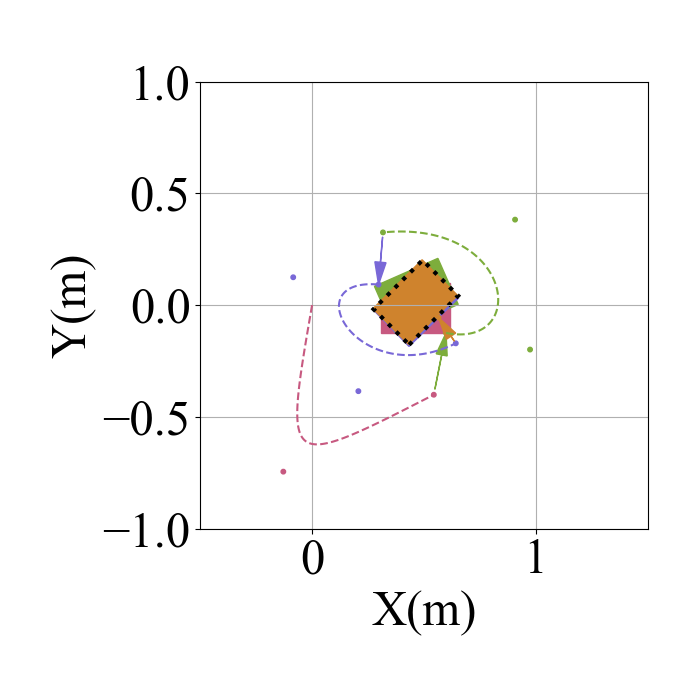

Point x,Point y,Impulse x,Impulse y,Point x local,Point y local,xbox,ybox,thetabox
0.599,-0.1245,0.09943125993179669,0.5028813171380652,0.13499999999999998,-0.1125,0.464,-0.012,0.0
0.2972639314557759,0.0920753594341494,-0.03606112171685105,-0.42429604713524927,-0.135,0.1125,0.46617323187424464,0.04358929718793815,0.4152006057873849
0.5655807862391052,-0.05589059791047253,-0.1403802828757114,0.20935852125539622,0.029518976829185445,-0.1125,0.4658873815794177,0.004016372138110239,0.7731001919151174
0.375,0.02007978690097894,0.28,0.28,0.0,0.0,0.0,0.0,0.0



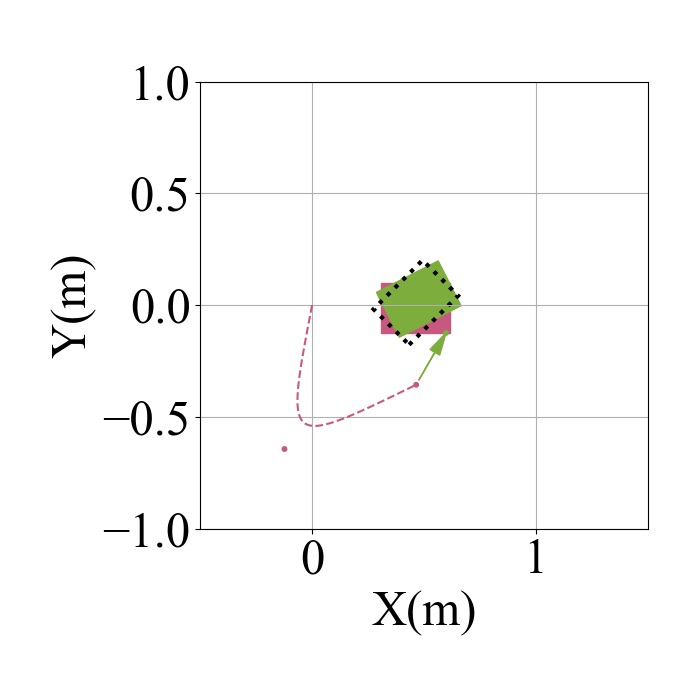

Point x,Point y,Impulse x,Impulse y,Point x local,Point y local,xbox,ybox,thetabox
0.599,-0.1245,0.24310378133214994,0.42167066223992483,0.13499999999999998,-0.1125,0.464,-0.012,0
0.375,0.02007978690097894,0.28,0.28,0.0,0.0,0.0,0.0,0



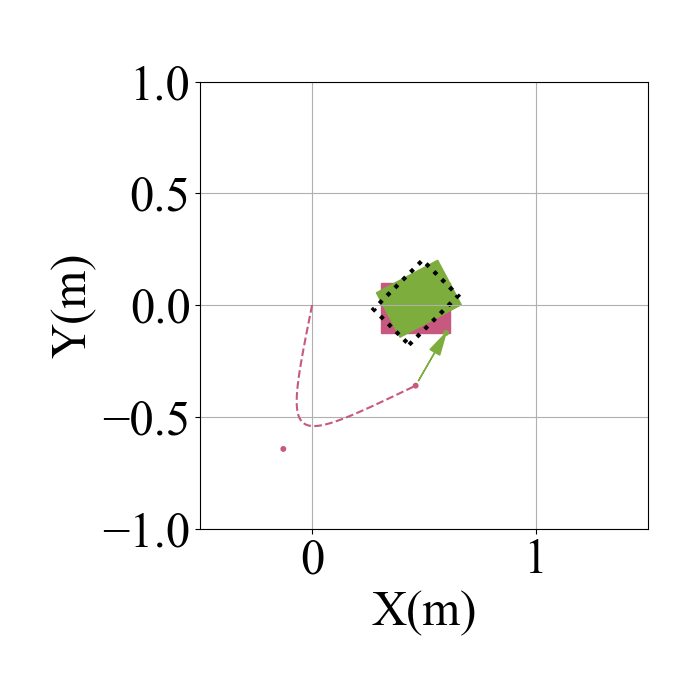

Point x,Point y,Impulse x,Impulse y,Point x local,Point y local,xbox,ybox,thetabox
0.599,-0.1245,0.2473026782775246,0.4289537725475109,0.13499999999999998,-0.1125,0.464,-0.012,0
0.375,0.02007978690097894,0.28,0.28,0.0,0.0,0.0,0.0,0



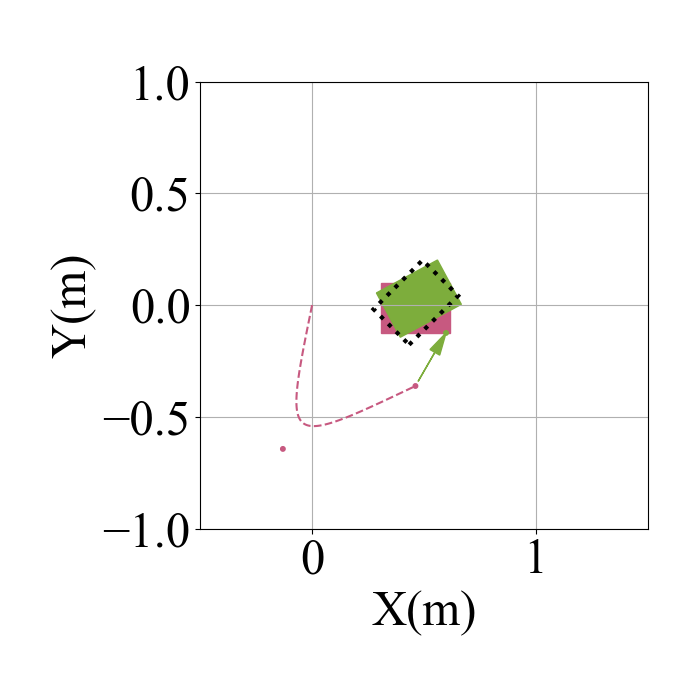

Point x,Point y,Impulse x,Impulse y,Point x local,Point y local,xbox,ybox,thetabox
0.599,-0.1245,0.248911953753679,0.4317451082150929,0.13499999999999998,-0.1125,0.464,-0.012,0
0.375,0.02007978690097894,0.28,0.28,0.0,0.0,0.0,0.0,0



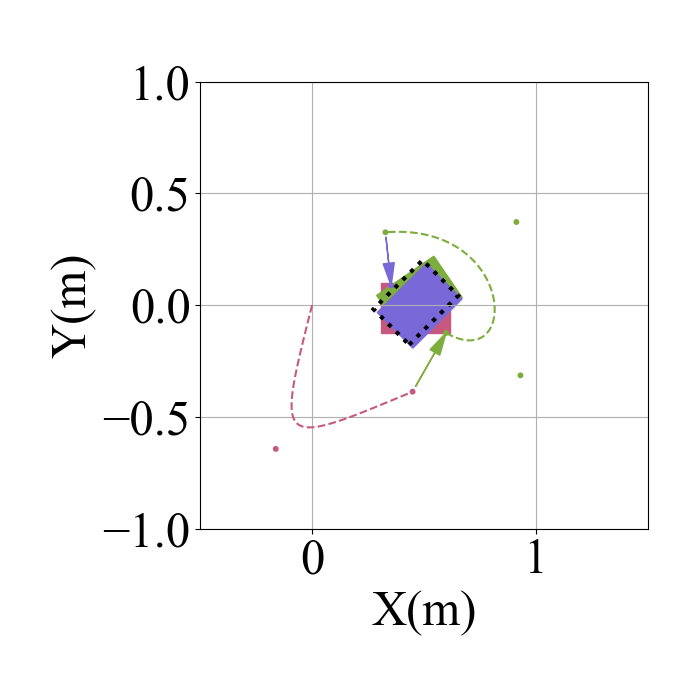

Point x,Point y,Impulse x,Impulse y,Point x local,Point y local,xbox,ybox,thetabox
0.599,-0.1245,0.2721454936390563,0.47795065675439175,0.13499999999999998,-0.1125,0.464,-0.012,0.0
0.3534561872188275,0.08766068547659175,0.046376083494668374,-0.43309644463699154,-0.07663591820329338,0.1125,0.4802803027099406,0.038214172063018484,0.6010398307434005
0.375,0.02007978690097894,0.28,0.28,0.0,0.0,0.0,0.0,0.0



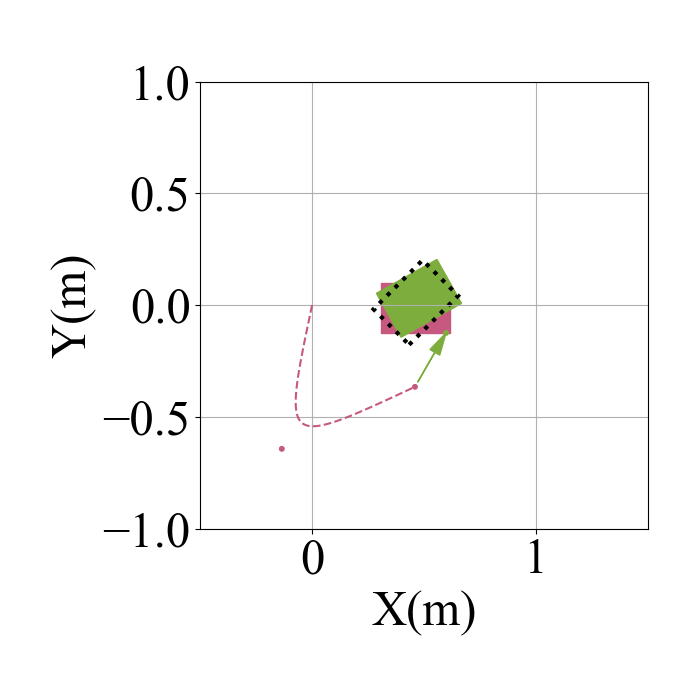

Point x,Point y,Impulse x,Impulse y,Point x local,Point y local,xbox,ybox,thetabox
0.599,-0.1245,0.2528070549219705,0.4385012758078994,0.13499999999999998,-0.1125,0.464,-0.012,0
0.375,0.02007978690097894,0.28,0.28,0.0,0.0,0.0,0.0,0



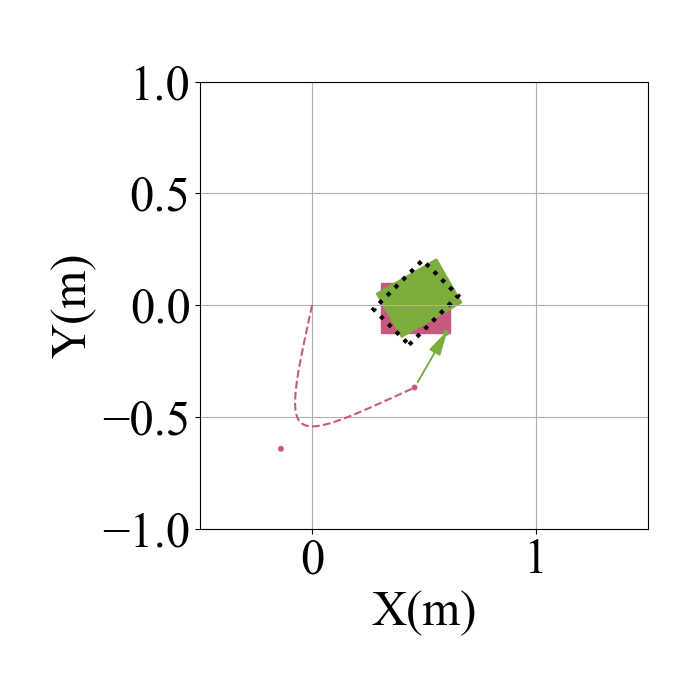

Point x,Point y,Impulse x,Impulse y,Point x local,Point y local,xbox,ybox,thetabox
0.599,-0.1245,0.25603365971231373,0.4440979167621247,0.13499999999999998,-0.1125,0.464,-0.012,0
0.375,0.02007978690097894,0.28,0.28,0.0,0.0,0.0,0.0,0



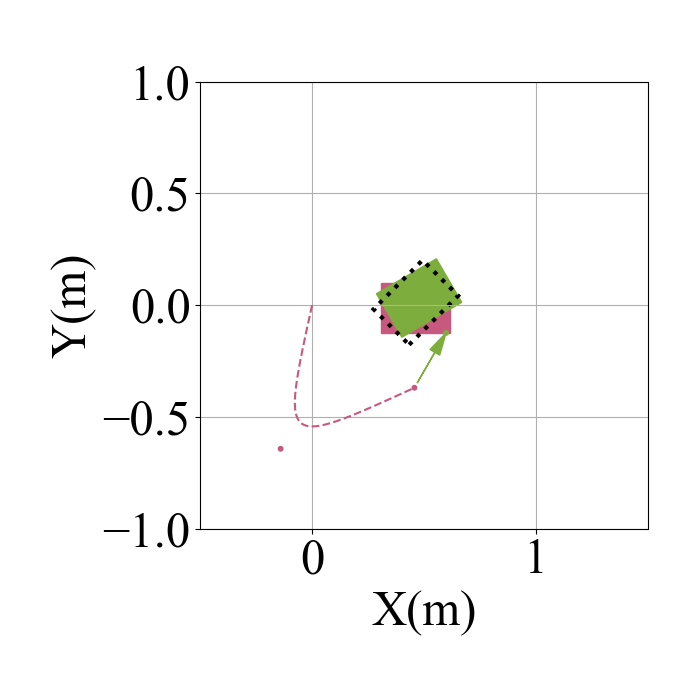

Point x,Point y,Impulse x,Impulse y,Point x local,Point y local,xbox,ybox,thetabox
0.599,-0.1245,0.25719847616856956,0.44611832518113764,0.13499999999999998,-0.1125,0.464,-0.012,0
0.375,0.02007978690097894,0.28,0.28,0.0,0.0,0.0,0.0,0



In [16]:
Save=True
savePDFidx = 5 # Figure number to save
for elite_num,selected_solution in enumerate(selected_solutions):
    filename = f"Travel_elite_{elite_num}_x={round(XTarget,3)}_y={round(YTarget,3)}.pdf"
    Evolution_Show(selected_solution, elite_num,filename,savePDFidx)